In [1]:
%load_ext autoreload
%autoreload 2
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
import torch
from tqdm import tqdm
import dvu
from typing import List
dvu.set_style()
import pandas as pd
from os.path import join as oj
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../experiments')
import config
pd.set_option('display.max_rows', None)

# extract the relevant model

In [2]:
cached_model_fname = oj(config.repo_dir, 'results', 'sst_bert_finetuned_ngrams=2.pkl')
row = pkl.load(open(cached_model_fname, "rb"))

# r = data.load_fitted_results(fname_filters=['bert-base', 'sub=-1'], dset_filters=['sst2'])
# row = r[(r.checkpoint == 'textattack/bert-base-uncased-SST-2') & (r.ngrams == 2)].iloc[0]
# row

/home/chansingh/.embgam/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# sst (not sst2) dataset

In [3]:
dset = datasets.load_dataset('sst', 'dictionary')

Reusing dataset sst (/home/chansingh/.cache/huggingface/datasets/sst/dictionary/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
dset

DatasetDict({
    dictionary: Dataset({
        features: ['phrase', 'label'],
        num_rows: 239232
    })
})

In [7]:
lens = list(map(lambda x: len(x.split()), dset['dictionary']['phrase']))
idxs = np.array(lens) <= 2
idxs_tri = np.array(lens) == 3
label = np.array(dset['dictionary']['label'])[idxs]
label_tri = np.array(dset['dictionary']['label'])[idxs_tri]
phrase = np.array(dset['dictionary']['phrase'])[idxs]
phrase_tri = np.array(dset['dictionary']['phrase'])[idxs_tri]

In [5]:
def get_scores(phrase):
    tokenizer = AutoTokenizer.from_pretrained(row.checkpoint) # for actually passing things to the model
    model = AutoModel.from_pretrained(row.checkpoint)
    logistic = row.model
    device = 'cuda'
    tokens = tokenizer(phrase.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)
    model = model.to(device)
    with torch.no_grad():
        output = model(**tokens) # has two keys, 'last_hidden_state', 'pooler_output'
    embs = output[row.layer].cpu().detach().numpy()
    # pkl.dump(embs, open('../results/embs_sst_unigram_bigram.pkl', 'wb'))
    scores = embs @ row.model.coef_.T
    return scores

In [10]:
scores = get_scores(phrase)
# scores_tri = get_scores(phrase_tri)

Some weights of the model checkpoint at textattack/bert-base-uncased-SST-2 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


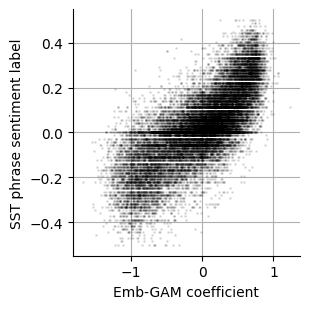

In [13]:
s = scores_tri
l = label_tri
# s = scores
# l = label

plt.figure(figsize=(3.2, 3.2))
# plt.title('B', fontweight='bold', loc='left')
plt.grid()
plt.plot(s, l - 0.5, '.', alpha=0.1, ms=2, color='black')
# df = pd.DataFrame.from_dict({'score': scores.flatten(), 'lab': label.flatten()})
# sns.lmplot(data=df, x='score', y='lab',markers='.')
plt.xlabel('Emb-GAM coefficient') #, fontsize='large')
plt.ylabel('SST phrase sentiment label') #, fontsize='large')
# plt.savefig('sst_embgam.pdf', bbox_inches='tight')
plt.tight_layout()
# plt.savefig('sst_embgam.png', dpi=300, bbox_inches='tight')
plt.savefig('sst_embgam_tri.png', dpi=300, bbox_inches='tight')